In [1]:
# pip install ipympl
%matplotlib widget
from logparser import get_events_from
from plotter import plot_gc, plot_membalancer_heap_rule
from GarbageCollector import MemBalancer
import numpy as np
import matplotlib.pyplot as plt

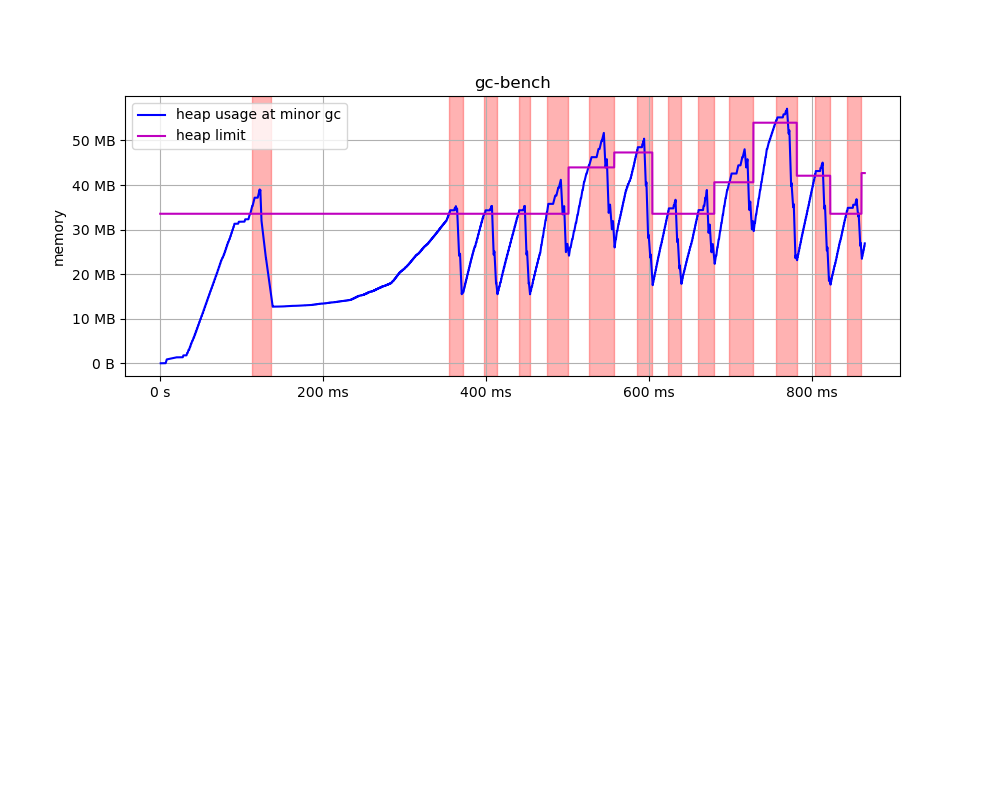

g_m: 0
heap_limit: 4196305, E: 0.0
g_m: 863328
heap_limit: 5279633.251865629, E: 1085328.2518656286
g_m: 467280
heap_limit: 5007835.628275432, E: 813530.6282754313
g_m: 434768
heap_limit: 5010039.344636273, E: 815734.3446362729
g_m: 560872
heap_limit: 5075406.81249015, E: 881101.8124901502
g_m: 690304
heap_limit: 5204849.223718136, E: 1010544.2237181357
g_m: 690328
heap_limit: 5316917.510079689, E: 1122612.5100796893
g_m: 689664
heap_limit: 5425743.038535822, E: 1231438.0385358224
g_m: 690352
heap_limit: 5526098.108703745, E: 1331793.1087037446
g_m: 691504
heap_limit: 5617581.678706985, E: 1423276.6787069854
g_m: 690464
heap_limit: 5704998.945370799, E: 1510693.9453707994
g_m: 688736
heap_limit: 5790325.820453139, E: 1596020.820453139
g_m: 690264
heap_limit: 5871601.267582592, E: 1677296.267582592
g_m: 689312
heap_limit: 5949480.701473756, E: 1755175.7014737555
g_m: 690928
heap_limit: 6026695.128429949, E: 1832390.1284299488
g_m: 688704
heap_limit: 6101737.823692902, E: 1907432.8236929

In [2]:
gcbench_events = get_events_from("logs/gcbench-3")
mem_balancer = MemBalancer(TUNING=0.0001)
mem_balancer.L_smoothed = 1
plot_gc(gcbench_events, "gc-bench", 1)
plot_membalancer_heap_rule(gcbench_events, mem_balancer,1)

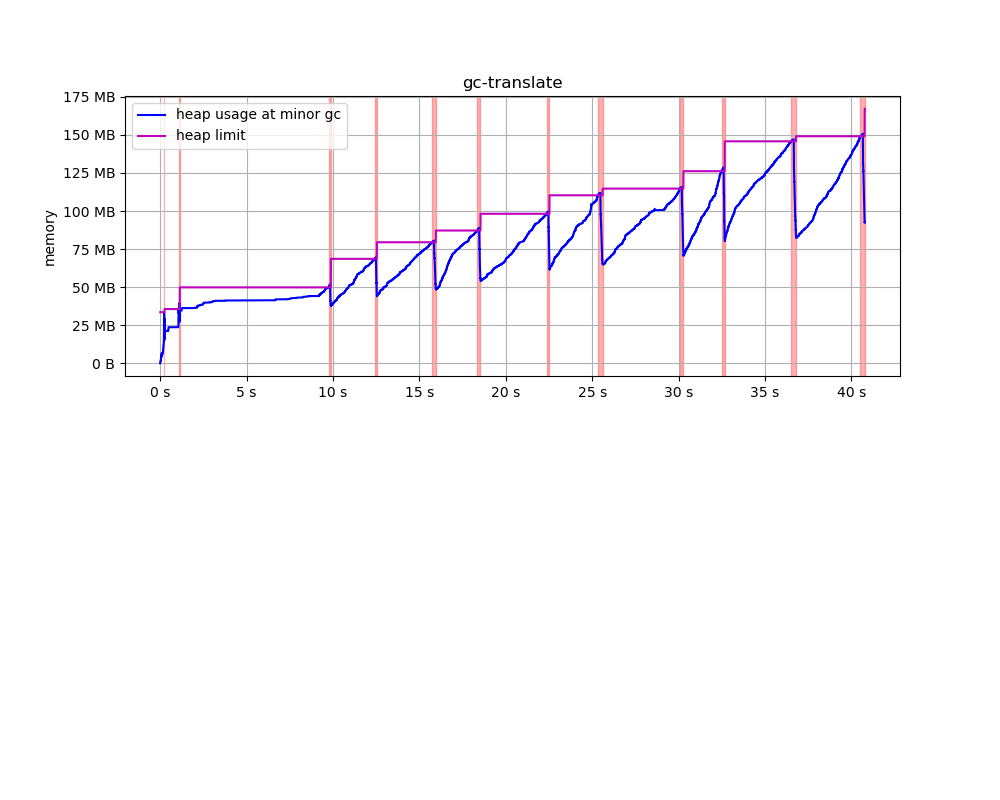

g_m: 0
heap_limit: 4196304, E: 0.0
g_m: 863488
heap_limit: 4196304, E: 0.0
g_m: 574360
heap_limit: 4196304, E: 0.0
g_m: 882144
heap_limit: 4196304, E: 0.0
g_m: 397424
heap_limit: 4196304, E: 0.0
g_m: 817800
heap_limit: 4196304, E: 0.0
g_m: 1017608
heap_limit: 4196304, E: 0.0
g_m: 1251128
heap_limit: 4196304, E: 0.0
g_m: 295032
heap_limit: 4196304, E: 0.0
g_m: 473544
heap_limit: 4196304, E: 0.0
g_m: 158392
heap_limit: 4196304, E: 0.0
g_m: 349120
heap_limit: 4196304, E: 0.0
g_m: 1116704
heap_limit: 4196304, E: 0.0
g_m: 917296
heap_limit: 4196304, E: 0.0
g_m: 960352
heap_limit: 4196304, E: 0.0
g_m: 962136
heap_limit: 4196304, E: 0.0
g_m: 878344
heap_limit: 4196304, E: 0.0
g_m: 1023992
heap_limit: 4196304, E: 0.0
g_m: 916984
heap_limit: 4196304, E: 0.0
g_m: 699976
heap_limit: 4196304, E: 0.0
g_m: 344144
heap_limit: 4196304, E: 0.0
g_m: 4276424
heap_limit: 4196304, E: 0.0
g_m: 4239744
heap_limit: 4196304, E: 0.0
g_m: 4235400
heap_limit: 4196304, E: 0.0
major collect start
g_m: 0
heap_limit:

In [4]:
gctranslate_events = get_events_from("logs/gctranslate-3")
mem_balancer = MemBalancer(TUNING=0.0001)
plot_gc(gctranslate_events, "gc-translate", fignum=2)
plot_membalancer_heap_rule(gctranslate_events, mem_balancer, 2)